Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [X] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [X] Engineer at least two new features. (See below for explanation & ideas.)
- [X] Fit a linear regression model with at least two features.
- [X] Get the model's coefficients and intercept.
- [X] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [X] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [X] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [78]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [79]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data

df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv',
                 parse_dates=['created'])
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [80]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48817 entries, 0 to 49351
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   bathrooms             48817 non-null  float64       
 1   bedrooms              48817 non-null  int64         
 2   created               48817 non-null  datetime64[ns]
 3   description           47392 non-null  object        
 4   display_address       48684 non-null  object        
 5   latitude              48817 non-null  float64       
 6   longitude             48817 non-null  float64       
 7   price                 48817 non-null  int64         
 8   street_address        48807 non-null  object        
 9   interest_level        48817 non-null  object        
 10  elevator              48817 non-null  int64         
 11  cats_allowed          48817 non-null  int64         
 12  hardwood_floors       48817 non-null  int64         
 13  dogs_allowed    

In [82]:
# create 2 new features
# lets create a total rooms column by adding bathrooms and bedrooms
df['total_rooms'] = df['bathrooms'] + df['bedrooms']
df['total_rooms']
# lets create a total ammenities column by adding up all the ammenities 
ammenities = df['elevator'],df['hardwood_floors'],df['doorman'],df['dishwasher'],df['laundry_in_building'],df['laundry_in_unit'],df['roof_deck'],df['outdoor_space'],df['dining_room'],df['high_speed_internet'],df['balcony'],df['swimming_pool'],df['fitness_center'],df['terrace'],df['garden_patio'],df['common_outdoor_space'],df['wheelchair_access']
df['total_ammenities'] = sum(ammenities)
df['total_ammenities'].value_counts()

0     11490
1      7271
2      6537
3      5811
4      4154
5      3416
6      3325
7      2350
8      1650
9      1262
10      793
11      420
12      215
13       98
14       25
Name: total_ammenities, dtype: int64

In [83]:
#lets extract the month and year from the 'created' column
df['month_year'] = pd.to_datetime(df['created']).dt.to_period('M')
df['month_year'].value_counts() #verified I got the results I was looking for 

2016-06    16973
2016-04    16217
2016-05    15627
Freq: M, Name: month_year, dtype: int64

In [109]:
# split target vector and feature matrix
y = df['price'] # our target
X = df[['total_ammenities','total_rooms']] # I'll use the features I created 
# split data train/test
cutoff =  '2016-05'
mask = df['month_year'] <= cutoff
X_train,y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]


In [110]:
# establish a baseline
# the following are 3 different metrics used to compare baseline to model
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

y_pred = [y_train.mean()] * len(y_train) 
print('y_train mean:', y_train.mean())
print('baseline MAE:',mean_absolute_error(y_train,y_pred).round(2)) # on average how far our prediction is from baseline
print('baseline MSE:',mean_squared_error(y_train,y_pred).round(2)) 
print('baseline R2 score:',r2_score(y_train,y_pred).round(2)) # not sure if I'm using this 1 right 

y_train mean: 3575.604007034292
baseline MAE: 1201.88
baseline MSE: 3105028.22
baseline R2 score: 0.0


In [114]:
# build my model 
from sklearn.linear_model import LinearRegression
# instantiate the model 
model = LinearRegression()
# fit training data to model 
model.fit(X_train , y_train)

y_pred = model.predict(X_train)

print('Train MAE:',mean_absolute_error(y_train,y_pred).round(2))
print('Train MSE:',mean_squared_error(y_train,y_pred,squared=False).round(2)) 
print('Train R2 score:',r2_score(y_train,y_pred).round(2))

Train MAE: 854.47
Train MSE: 1291.5
Train R2 score: 0.46


In [111]:
# MAE train vs test
print('Training MAE:',mean_absolute_error(y_train,model.predict(X_train)).round(2))
print('Test MAE:', mean_absolute_error(y_test,model.predict(X_test)))


Training MAE: 854.47
Test MAE: 864.8393837721005


In [97]:
# MSE train vs test 
print('Train MSE:',mean_squared_error(y_train,model.predict(X_train),squared=False))
print('Test MSE:',mean_squared_error(y_test,model.predict(X_test),squared=False))

Train MSE: 1291.5021718826847
Test MSE: 1289.3623524132815


In [113]:
# R-squared 
print('Training R^2 score:', r2_score(y_train,model.predict(X_train)))
print('Test R^2 score:', r2_score(y_test,model.predict(X_test)))

Training R^2 score: 0.4628139446956502
Test R^2 score: 0.46510814034121517


In [116]:
# model coef values and intercept

print(f'price = {model.intercept_} + {model.coef_[0]} * # of ammenities + {model.coef_[1]} * # of total rooms')

price = 1097.8969039576104 + 126.39294860552697 * # of ammenities + 763.8005703124978 * # of total rooms


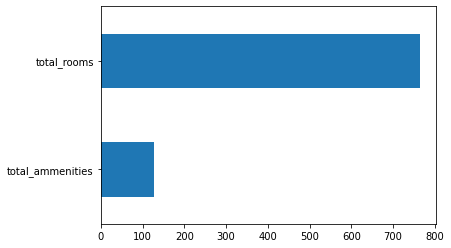

In [115]:
pd.Series(model.coef_, index=X_train.columns).plot(kind='barh')